# Detecting selection with deep learning

## Examples and exercises using _keras_ and _ImaGene_

#### Motivation

In this practical our aim is to predict whether a given locus is under natural selection from population genomic data. 
We will implement a deep learning algorithm to this aim, and use [_keras_](https://keras.io/) for implementing the network and [_ImaGene_](https://github.com/mfumagalli/ImaGene) for manipulating data. Both are accessible through _python_.
The goal of this exercise is not to learn of specific functions in _ImaGene_ work, but how you can manipulate genetic data for machine learning and how you can build simple algorithms and architectures in _keras_.

In this specific example, we will perform a **binary classification** on the classic example of positive selection for lactase persistence in human European populations.

Why lactase persitence? Why in Europeans?

The C/T(-13910) variant, or rs4988235, is located on chromosome 2 in the _MCM6_ gene but influences the lactase _LCT_ gene. This SNP is associated with the primary haplotype associated with lactose intolerance in European populations. 
In these populations, the common T allele is associated with lactase persistence. Individuals who are homozygous for C allele are likely to be lactose intolerant. 

---------------------------------------------------------------------------

#### Data

We extracted SNP information from a region of 80k base pairs around the target variant rs4988235 from the 1000 Genomes Project data for all unrelated individuals of CEU population (of European descent).
The data is in the form of a VCF file.

In this practical, you will learn how to:
1. read data from VCF file and store it into _python_ objects,
2. process simulations to be used for training,
3. implement, train and evaluate a neural network,
4. deploy the trained network on your genomic data of interest.

--------------------------------------------------------------------------

The first part is a guided exercise to perform a simple task. In this way, you will learn how to build models in _keras_ and use _ImaGene_ to manipulate data.
In the second part, you will be asked to perform more complex tasks and fill in the missing bits in the code to perform such task.

### Guided exercise

We need to load the necessary modules in _python_.

In [1]:
import os
import gzip
import _pickle as pickle

import numpy as np # actual haplotype data is stored as numpy arrays
import scipy.stats
import arviz

import tensorflow as tf # we will be using keras with tensorflow as backend
from tensorflow import keras
from keras import models, layers, activations, optimizers, regularizers
from keras.utils.vis_utils import plot_model
from keras.models import load_model

import itertools
import matplotlib.pyplot as plt # for plotting purposes
import skimage.transform
from sklearn.metrics import confusion_matrix

%run -i ../ImaGene.py # functions to manipulate VCF and simulation files

### 1. Read data from VCF file and store it into _ImaGene_ objects

We store the information of the genomic data into an _ImaFile_ object where we specify the name of the VCF file and the number of samples (i.e. the number of chromosomal copies, twice the number of individuals for a diploid organism).
The latter parameter is not strictly necessary but it is useful to check whether the VCF we are analysing contains the data that we expect.

In the example below, we load 198 haplotypes (from 99 human diploid samples) from the 'LCT.CEU.vcf' file.

In [2]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='LCT.CEU.vcf')

We create an _ImaGene_ object by reading the VCF file and generating a matrix of haplotypes.

In [3]:
gene_LCT = file_LCT.read_VCF()

An _ImaGene_ object has a series of useful methods that can be visualised with `gene_LCT.` and press tab.

In [ ]:
gene_LCT.

For instance, we can have a quick look at the data stored in this object.

In [4]:
gene_LCT.summary();

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 2200, max 2200, mean 2200.000000, std 0.000000


As expected, we have one image with 198 rows (equivalent to the number of sampled chromosomal copies) and 2200 columns representing all genomic positions reported.
It is likely that not all of these positions will be polymorphic in the CEU sample as the VCF file reports variats across all analysed populations.

Similarly, we may want to discard rare variants as they may be more associated to errors or be less informative of the scenario we want to predict.
Assume that we want to ignore monomorphic sites and singletons for the derived allele.
We can accomplish this with the following command.

In [5]:
gene_LCT.filter_freq?

In [6]:
gene_LCT.filter_freq(0.01);

If we are unsure about the ancestral/derived polarisation of alleles, we can convert them into major/minor alleles using the method `.majorminor()`. 
We can have a look at the resulting image.

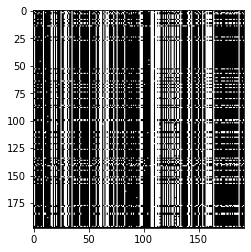

In [7]:
gene_LCT.plot();

As the order on the rows is arbitrary, we can order them (and columns) following several criteria.
We can do this with _ImaGene_ with the `.sort` method which has the following options.

In [8]:
gene_LCT.sort?

Assume that we wish to sort only rows by their frequency (with the most frequent haplotypes on the top).
This can be done with the following command (which will also visualise the resulting image).

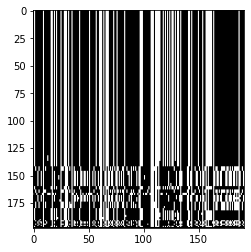

In [9]:
gene_LCT.sort('rows_freq');
gene_LCT.plot();

Once we are happy with our data processing (e.g. filtering and sorting), we need to convert the image into an appropriate format which will be later used for the prediction.
As an illustration, we also flip black and white pixels to assign the former to derived (or minor) alleles which is the standard representation of genomic data.

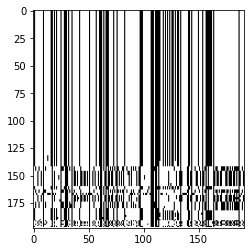

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


In [10]:
gene_LCT.convert(flip=True); # this step is mandatory
gene_LCT.plot();
gene_LCT.summary();

We finally note that our image has 192 columns now, representing the number of retained SNPs.

We can save our _ImaGene_ object in the working `path = './'` directory with `gene_LCT.save(file=path + 'gene_LCT');`.
As a further illustration, the following line `gene_LCT = load_imagene(file=path + 'gene_LCT')` will load the _ImaGene_ object from a saved file. 

### 2. Process simulations to be used for training the neural network

_ImaGene_ provides users with an easy interface with [_msms_](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2916717/) to run simulations which will be used for training the network.
However, we already provide simulations a total of 
loci of 80kbp either under neutral evolution or positive selection with additive effect and an allelic selection coefficient of either $0.75$\% and $1.5$\% targeting a variant in the middle of the region.
We imposed that selection starts 800 generations ago (corresponding to 20kya with a generation time of 25 years) with an allele frequency of $0.01$.

We impose a mutation rate is $1.5e-8$ per base per generation and a recombination rate of $1e-8$.
Finally, the simulated population follows a 3-epoch model of bottleneck and expansion as proposed by [Marth et al. 2004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1470693/) for a European population.
We sampled 198 chromosomal copies to match our observed data.

Let's process these simulations to be then fed as training data to our algorithm.
To do that, we need to read and store simulations into an _ImaFile_ object.

In [ ]:
import subprocess
subprocess.call("tar xvf Data.tar.gz".split());

This script will split the simulation folder into different batches to later perform training with a (pseudo)-simulation-on-the-fly approach.

Specifically, we will simulate 10 different batches (folders ) of simulations 1-10:

| 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |

Each batch (folder) contains 400 simulations. We reserve the last one (nr 10) for testing. We will go over the training on batch 1 as an example, and then run training on 2-9 batches in a more automated way. We will reserve a proportion of simulations within each batch for validation.

Let's perform the first iteration of training on the first batch of simulations.

In [11]:
file_sim = ImaFile(simulations_folder='Data/Simulations1', nr_samples=198, model_name='Europe');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain. 
As a quick example, we will use only 200 data points per class. You can use up to 400 data points in this data set.

In [13]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=200);

We can have a look at the data stored in this object.

In [14]:
gene_sim.summary();

An object of 600 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 164, max 458, mean 293.775000, std 60.734046


We have 600 images in this object. Recall that with the first line we simulated 3 classes and retained 200 data points for each class. All images have 198 rows as expected, as this represents the number of simulated haplotypes. However, images have different number of columns, ranging from $143$ to $434$ with an average value of $\approx 283$. The number of columns represents the number of polymorphic sites and fixed derived alleles in a _msms_ file. This number may vary from simulated gene to another.
Our observed data for LCT has 192 columns.

We can check the sample allele frequency for the selected allele. Recall that we imposed selection to be acting in the middle of the region. Therefore, the targeted allele will be in position '0.5' in the _msms_ file.

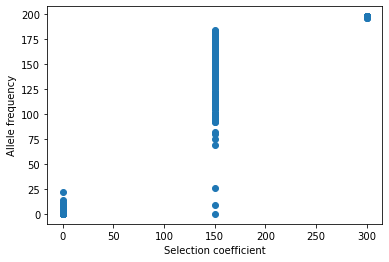

In [15]:
freqs = calculate_allele_frequency(gene_sim, 0.5);
plt.scatter(gene_sim.targets, freqs, marker='o');
plt.xlabel('Selection coefficient');
plt.ylabel('Allele frequency');

As mentioned before, _ImaGene_ provides functionalities to manipulate our data. Specifically we can do the following:
* convert ancestral/derived to major/minor allele polarisation
* filter out columns based on a minimum allele frequency (e.g. 0.01)
* sorting rows and columns by frequency (or genetic distance from the most frequent entry)

We need to follow the same data processing as the one employed for the real data.

In [16]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');
gene_sim.summary();

An object of 600 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 102, max 364, mean 215.060000, std 50.832238


All images must have the same dimensions. You can explore all different options for resizing as alternative solutions to padding.

In [17]:
?gene_sim.resize

One possibility would be to resize them to match the dimensions of the real data.
In this case it means resize all images to have shape (198, 192) which can be achieved with the following command.

In [18]:
gene_sim.resize((198, 192));
gene_sim.summary();

An object of 600 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


After the data manipulation is done, we need to convert images to proper _numpy_ float matrices, as previously discussed. The following line will do the job (including flipping black/white pixels). 
Note that the `.convert` method allows you to normalise the data too.

In [19]:
gene_sim.convert(flip=True);
gene_sim.summary();

An object of 600 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


Note that in addition to the genomic data, an _ImaGene_ object contains information on the corresponding targets (in this case the selection coefficient, either 0, 200, or 400 in $2N_e$ units with $N_e = 10000$).
As an illustration, let's plot one random image per class.

0


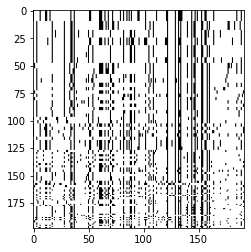

150


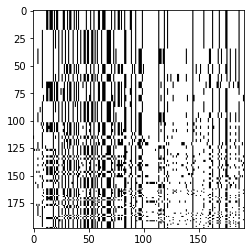

300


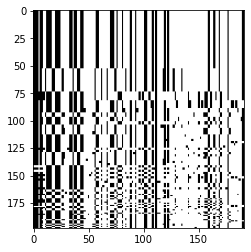

In [20]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

For this guided example, we just assume to have 2 classes, either neutrality (0) or strong selection (300).

In [21]:
gene_sim.classes = np.array([0,300]);
gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes));
gene_sim.summary();

An object of 400 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


Finally we need to randomly shuffle our images before using them for training our network.
We can easily accomplish this with the following line.

In [22]:
gene_sim.subset(get_index_random(gene_sim));

Our targets represent the 2 possible classes. However, since we are doing a binary classification, we need to vectorise them as required by _keras_.

In [23]:
gene_sim.targets = to_binary(gene_sim.targets);

The object is now ready to be used for the classification!
You can save it with `gene_sim.save(file=path + 'gene_sim.binary');`. If you want to load an _ImaGene_ object you can use the following function `gene_sim = load_imagene(file=path + 'gene_sim.binary');`

### 3. Implement, train and evaluate the neural network

Now that our data is ready, we can build our network.
Specifically, we can build a model in _keras_ with convolutional, pooling and dense layers.

We will be using the [Sequential model](https://keras.io/guides/sequential_model/) which is "very straightforward (a simple list of layers), but is limited to single-input, single-output stacks of layers (as the name gives away)."

The layers can be specified like described [here](https://keras.io/api/layers/).

In this example we have 2 layers of [2D convolutions](https://keras.io/api/layers/convolution_layers/convolution2d/) and [2D pooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/) followed by a fully-connected [dense](https://keras.io/api/layers/core_layers/dense/) layer.
We just need to specify the dimensions of the data in the first layer, and this is specified by the option `input_shape=gene_sim.data.shape[1:]`.

In [24]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

2022-06-14 13:45:33.254951: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Then, let's [compile](https://keras.io/api/models/model_training_apis/) our _keras_ model.

In [25]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

A list of all loss functions is [here](https://keras.io/api/losses/).
Let's look at a summary of the model. You can also plot it with `plot_model(model, path + 'net.binary.png')`.

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 95, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 46, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 141312)            0         
                                                                 
 dense (Dense)               (None, 128)               1

Now we are ready for doing the training on this first batch of data.

In [27]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

2022-06-14 13:46:46.032029: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 305070080 exceeds 10% of free system memory.
2022-06-14 13:46:46.978525: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 305070080 exceeds 10% of free system memory.


1/6 [====>.........................] - ETA: 9s - loss: 4.8081 - accuracy: 0.4844

2022-06-14 13:46:47.364339: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 305070080 exceeds 10% of free system memory.
2022-06-14 13:46:48.274263: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 305070080 exceeds 10% of free system memory.


2/6 [=========>....................] - ETA: 5s - loss: 17.4585 - accuracy: 0.5234

2022-06-14 13:46:48.680345: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 305070080 exceeds 10% of free system memory.


6/6 [==============================] - 8s 1s/step - loss: 13.2416 - accuracy: 0.5306 - val_loss: 4.2417 - val_accuracy: 0.5000


Remember that you can save a _keras_ model with `model.save('net.h5')`.

Now we can initialise a network object _ImaNet_.

In [28]:
net_LCT = ImaNet(name='binary_task')

We can keep track of scores (loss and accuracy) across iterations with `.update_scores`.

In [29]:
net_LCT.update_scores(score);

Now we need to repeat the whole procedure described above using all remaning batches of data, leaving the last one for testing.

In [30]:
i = 2
while i < 10:

    print(i)
    
    file_sim = ImaFile(simulations_folder='Data/Simulations' + str(i), nr_samples=198, model_name='Europe')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=200)
    
    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.classes = np.array([0,300]); 
    gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes));

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)
     
    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)
    net_LCT.update_scores(score)
   
    i += 1

2
6/6 [==============================] - 8s 1s/step - loss: 4.1474 - accuracy: 0.5472 - val_loss: 3.9167 - val_accuracy: 0.9750
3
6/6 [==============================] - 8s 1s/step - loss: 4.3247 - accuracy: 0.8222 - val_loss: 3.8036 - val_accuracy: 0.8500
4
6/6 [==============================] - 8s 1s/step - loss: 3.8061 - accuracy: 0.7444 - val_loss: 3.6644 - val_accuracy: 0.5500
5
6/6 [==============================] - 8s 1s/step - loss: 3.5910 - accuracy: 0.6417 - val_loss: 3.4657 - val_accuracy: 0.5750
6
6/6 [==============================] - 8s 1s/step - loss: 3.3415 - accuracy: 0.7750 - val_loss: 4.5448 - val_accuracy: 0.4500
7
6/6 [==============================] - 8s 1s/step - loss: 3.6146 - accuracy: 0.6806 - val_loss: 3.1276 - val_accuracy: 0.9250
8
6/6 [==============================] - 8s 1s/step - loss: 3.3003 - accuracy: 0.7722 - val_loss: 3.0574 - val_accuracy: 0.9250
9
6/6 [==============================] - 8s 1s/step - loss: 2.9095 - accuracy: 0.9028 - val_loss: 5.0540

We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

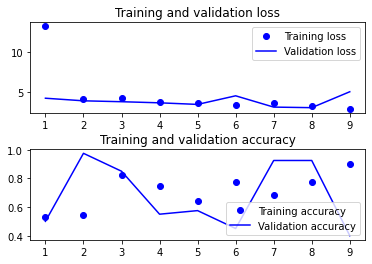

0

In [31]:
net_LCT.plot_train()

You can save (and/or load) the final trained model with `model.save(path + 'model.binary.h5')` and `model = load_model(path + 'model.binary.h5')`.
You can also save the network itself (and load it) with `net_LCT.save(path + 'net_LCT.binary');` and `net_LCT = load_imanet(path + 'net_LCT.binary')`.

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [32]:
i = 10
file_sim = ImaFile(simulations_folder='Data/Simulations' + str(i), nr_samples=198, model_name='Europe')
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=200)

gene_sim.filter_freq(0.01)
gene_sim.sort('rows_freq')
gene_sim.resize((198, 192))
gene_sim.convert(flip=True)

gene_sim.classes = np.array([0,300]); 
gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes));

rnd_idx = get_index_random(gene_sim) # no need to create this extra variable
gene_sim.subset(rnd_idx)

gene_sim.targets = to_binary(gene_sim.targets);

Let's report loss and accuracy on the testing set.

In [33]:
net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]

[4.570390701293945, 0.5]


For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

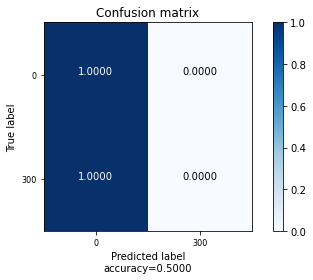

0

In [34]:
net_LCT.predict(gene_sim, model)
net_LCT.plot_cm(gene_sim.classes, text=True)
#net_LCT.plot_cm([0,300], text=True)

### 4. Deploy the trained network on your genomic data of interest

Finally we can use the trained network to predict natural selection on our locus of interest.
The output of this command will give us the class score (from 0 to 1) of said locus under positive selection under the conditions we simulated.

In [35]:
print(model.predict(gene_LCT.data, batch_size=None)[0][0])

0.14171353


## BYOB (Build Your Own Best network)

Now it's your turn to build your own deep learning algorithm to perform more challenging tasks: 
1. redo the above example of a binary classification [0, 300],
2. a new binary classification [0, 150], or
3. a multiclass classification [0, 150, 300].

Be aware that in the latter case, loss and activation functions change. Check [keras](https://keras.io/) and the links provided in the guided example for the correct definition and setting of these parameters.

-----------------------------------

Few suggestions or directions you can take (in order of complexity):
- use different filtering (`.filter_freq`), ordering (`.sort`), resizing (`.resize`), or allelic polarisation (`.majorminor`) options
- change the capacity or depth of your network by modifying the number of layers, filters, dimension of kernels, padding, or regularization
- implement a permutation-invariant function (e.g. with an AveragePooling layer) in combination with 1D convolution (or better phrased, as Conv2D with (1,x) dimensions)

Don't forget to check for overfitting and, in case, add a [DropOut](https://keras.io/api/layers/regularization_layers/dropout/) or [BatchNormalisation](https://keras.io/api/layers/normalization_layers/batch_normalization/) layer or modify the hyper-parameters of regularisation).

Calculate the testing accuracy **at the very end**, only once you are satisfied with your data processing and architecture. You can monitor interim performance with the validation accuracy.
Remember that you can use up to 400 data points for each simulation batch.

Feel free to work in pairs, groups or go solo, whatever suits you.
I provide some help code so you can focus on only lines and parameters that matter.

**Be creative and enjoy!**

In [ ]:
# help code: model

model = models.Sequential([
                    layers....(filters=.., kernel_size=..., strides=..., activation='relu', kernel_regularizer=..., padding='valid', input_shape=(198,...,1)),
                    ... # add/modify as you wish
                    layers.Flatten(),
                    layers.Dense(units=..., activation='relu'),
                    layers.Dense(units=..., activation=...)]) # what's the dimension of the final output? 
                    # what's the activation funtion of the final layer?

model.compile(optimizer=..., # pick on
              loss=..., # what is the loss function for multiclass classification?
              metrics=['accuracy'])

In [ ]:
# help code: training

net_LCT = ImaNet(name='multiclass_task') # it simply initialises this object

i = 1
while i < 10: # loop from simulation batch 1 to 9, leave 10 for testing

    print(i)
    
    file_sim = ImaFile(simulations_folder='Data/Simulations' + str(i), nr_samples=198, model_name='Europe') # mandatory
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=...) # fill in nr of replicates per class you wish to retain
    
    gene_sim.... # filter/manipulate data as you wish
    
    gene_sim.resize((..., ...))
    gene_sim.convert(flip=True) # mandatory

    # if you use a subset of the simulations:
    # for e.g. multiclass:
    gene_sim.classes = np.array([0,150,300]); # change np.array([0,150,300]) accordingly
    gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes));
        
    gene_sim.subset(get_index_random(gene_sim)) # mandatory
    
    gene_sim.targets = to_binary(gene_sim.targets) # mandatory for binary classification
    # or
    gene_sim.targets = to_categorical(gene_sim.targets) # mandatory for multiclass: it converts to a suitable format
     
    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=...) # how much data do you wish to retain for validation
    net_LCT.update_scores(score) # mandatory
   
    i += 1



In [ ]:
# help code: testing

i = 10
file_sim = ImaFile(simulations_folder='Data/Simulations' + str(i), nr_samples=198, model_name='Europe')
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=...)

gene_sim....

gene_sim.resize((..., ...))
gene_sim.convert(flip=True) # mandatory

gene_sim.classes = np.array([0,150,300]); # change np.array([...]) accordingly
gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes));

gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes)) # mandatory

gene_sim.targets = to_binary(gene_sim.targets) # mandatory for binary classification
# or
gene_sim.targets = to_categorical(gene_sim.targets) # mandatory for multiclass: it converts to a suitable format

net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]

net_LCT.predict(gene_sim, model)
net_LCT.plot_cm(gene_sim.classes, text=True) # confusion matrix


In [ ]:
# help code: deployment

... # remember to filter/manipulate VCF file in the same way you did for the simulations!

print(model.predict(gene_LCT.data, batch_size=None)[0][0])